# Time-series prediction with Keras `SimpleRNN` class
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---
### What is this Notebook about?
In this notebook, we show a building simple recurrent neural network (RNN) using Keras.

We will generate some synthetic time-series data by multiplying two periodic/ sinusoidal signals and adding some stochasticity (Gaussian noise). Then, we will take a small fraction of the data and train a simple RNN model with it and try to predict the rest of the data and see how the predictions match up with the ground truth.

In [ ]:
# para el conjunto de entrenamiento partimos los datos como el way 1 y luego para entrenar lo hacwemos en el way3 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [2]:
# Total time points
N = 3000
# Time point to partition train/test splits
Tp = 750   

t=np.arange(0,N)
x=(2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
df.head()

Data
0  0.593732
1  0.146483
2  0.583860
3  0.956187
4  0.890083

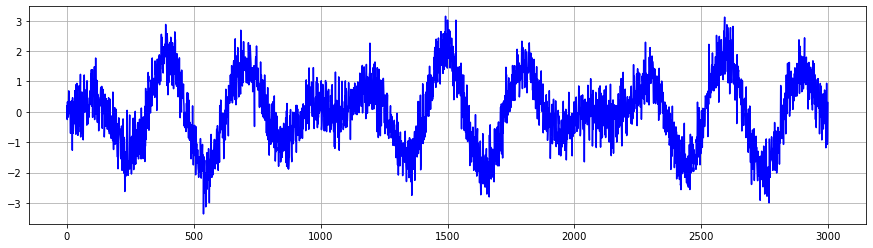

In [84]:
plt.figure(figsize=(15,4))
plt.plot(df,c='blue')
plt.grid(True)
plt.show()

### Split the values in train and test

So, we took only 25% of the data as training samples and set aside the rest of the data for testing. 

Looking at the time-series plot, we think **it is not easy for a standard model to come up with correct trend predictions.**

In [ ]:
# Todo esto es la forma de entrenar 1 es decir la de entrenar el pasado y luego se testea y predice en el presente 

In [3]:
values = df.values
train  = values[0:Tp ,:]
test = values[Tp:N,:]

In [4]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (750, 1)
Test data length: (2250, 1)


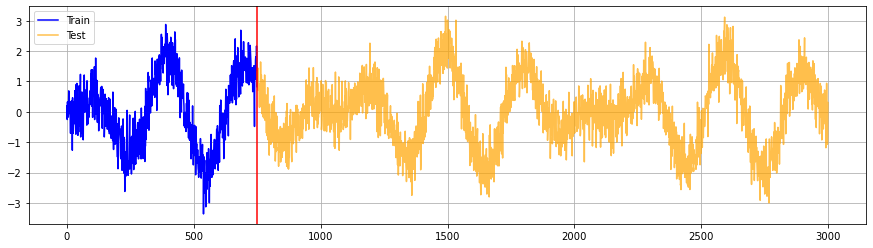

In [96]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp],train,c='blue')
plt.plot(index[Tp:N],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.show()

In [ ]:
# este step es para entrenar como en el way3 que va poco a poco en el gráfico, pasando poquito a poquito la ventana 

### Step (or _embedding_)
RNN model requires a step value that contains n number of elements as an input sequence.

Suppose x = {1,2,3,4,5,6,7,8,9,10}

for step=1, x input  and its y prediction are:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| ...  | ...  |
| 9  | 10  |

for step=3, x and y contain:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |
| ...  | ...  |
| 7,8,9  | 10  |

Here, we choose `step=4`. In more complex RNN and in particular for text processing, this is also called _embedding size_.

In [5]:
train.shape

(750, 1)

In [ ]:
# el ultimo valor se repetira 4 veces por que estamos usando step 4. Con la función nrepeat se repite 4 veces o el step que tenemos


In [6]:
step = 4
np.append(train,np.repeat(train[-1,],step)).shape

(754,)

In [7]:
train[-1,]

array([0.80667072])

In [8]:
np.repeat(train[-1],step) 

array([0.80667072, 0.80667072, 0.80667072, 0.80667072])

In [10]:
np.append(train,np.repeat(train[-1,],step))[-8:]

array([1.34702708, 0.54027455, 1.76959323, 0.80667072, 0.80667072,
       0.80667072, 0.80667072, 0.80667072])

In [11]:
train[-8:]

array([[0.23937805],
       [1.14586826],
       [1.39093178],
       [1.32769187],
       [1.34702708],
       [0.54027455],
       [1.76959323],
       [0.80667072]])

In [12]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (750, 1)
Test data length: (2250, 1)


In [13]:
step = 4

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step)) #añadiendo al conjunto de train los 4 ultimos valores

In [14]:
train[-8:]

array([1.34702708, 0.54027455, 1.76959323, 0.80667072, 0.80667072,
       0.80667072, 0.80667072, 0.80667072])

In [15]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (754,)
Test data length: (2254,)


### Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [ ]:
# esta función nos hace pasar de un array de 754 a un array de 750 valores pero de 4 elementos. por que x_train[0] es un solo valor, pero queremos 4 

In [16]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [17]:
trainX,trainY = convertToMatrix(train,step)
testX,testY = convertToMatrix(test,step)

trainX.shape

(750, 4)

In [ ]:
## Explicación del step
# Es mejor enseñarle los patrones de los:
# - 4 últimos días
# - 3 últimos días
# -2 últimos días

# step = 4
x = [1,2,3,4,5,6,7,8,8,8,8,8]
x_train[0] = [1,2,3,4]
y_train[0] = 5


x_train[1] = [2,3,4,5]
y_train[1] = 6

x_train[2] = [3,4,5,6]
y_train[2] = 7

x_train[3] = [4,5,6,7]
y_train[3] = 8

x_train[4] = [5,6,7,8]
y_train[4] = 8


# se añaden los últimos 4 para enseñarle el presente mas cercano al 6,7,8 no con el 5 que es otro patron. El pasado mas presente es el que mas impacto tiene, si no agregamos no vamos a llegar a coger el 5, 6, 7 y hasta 8 si no solo llegariamos hasta el 6 y nos importan los valores ultimos 

In [18]:
trainX[0]

array([0.59373189, 0.1464826 , 0.58385955, 0.95618744])

In [19]:
trainX[1]

array([0.1464826 , 0.58385955, 0.95618744, 0.89008252])

In [20]:
trainX[2]

array([ 0.58385955,  0.95618744,  0.89008252, -0.59341223])

In [21]:
print("trainX.shape:", trainX.shape)
print("trainX.shape[0]:", trainX.shape[0]) # nº batches
print("trainX.shape[1]:", trainX.shape[1]) # las dimensiones ( 4 valores por step = 4 )

trainX.shape: (750, 4)
trainX.shape[0]: 750
trainX.shape[1]: 4


In [ ]:
## aqui hacemos un reshape para transformar a una fila de 750 baches de una fila y 4 columnas 4

In [22]:
# traducir lo de abajo, esta es la explicación
trainX_2 = np.reshape(trainX, (750, 1, 4))

In [23]:
# Esto es para convertir los 750, 1, 4
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Para entrenar el modelo, necesito que los datos tengan la siguiente dimensión:

(750, 1, 4)

- 750: el número total de trozos 
- 1: una fila de datos
- 4: cada trozo tiene cuatro valores

En el caso de una imagen, recordemos con un ejemplo: 

(750, 28, 28)

750 imágenes de resolución 28x28

In [24]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (750, 1, 4) ,  (750,)
Test data shape: (2250, 1, 4) ,  (2250,)


### Keras model with `LSTM` layer

- 256 neurons in the RNN layer
- 32 neurons in the densely connected layer
- a single neuron for the output layer
- ReLu activation
- learning rate: 0.001

In [ ]:
# un solo valor de salida por que es regresión

In [25]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

def build_simple_rnn(num_units=128, embedding=4, num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length (numero de pasos o step)
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    # Long short term memory
    model.add(LSTM(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [26]:
model = build_simple_rnn() # Taking the defaults
#model.save("my_model.h5")

C:\Users\Mary\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [27]:
model.summary() # los 68k salen delos 128*128*4(pasos) y lo que falta son los bayas de lo que entra a si mismo multiplicados por en embedding que hay

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 72,257
Trainable params: 72,257
Non-trainable params: 0
_________________________________________________________________


### A simple callback class to show a message every 50 epochs

In [35]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

### Fit the model

Con batch_size = 16 lo que haríamos es que cogemos los datos de esta forma:

- (16, 1, 4)

Cogemos 16 trozos de 1 fila con 4 datos

In [ ]:
#aqui lo que le damos de 16 en 16 trozos 

In [36]:
batch_size=16
num_epochs = 1000

In [37]:
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0) # el verbose = 1 es opcional, solo que si lo ponemos nos van a salir 1000 epocas

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


In [123]:
model.save("my_model2.h5")

### Plot loss

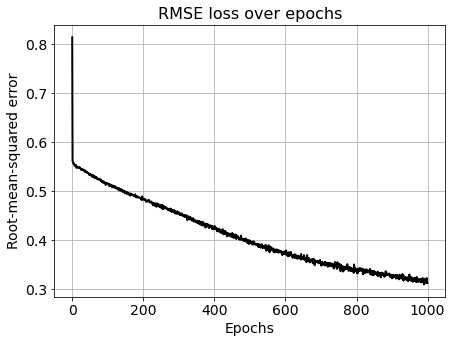

In [36]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Predictions
Note that the model was fitted only with the `trainX` and `trainY` data. 

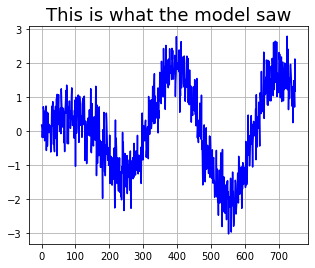

In [37]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

In [38]:
trainPredict = model.predict(trainX) #1. predecir tanto el conjunto de entrenamiento 
testPredict = model.predict(testX) #2. predecir el conjunto de test
predicted = np.concatenate((trainPredict,testPredict),axis=0) #3. concatenar ambos 

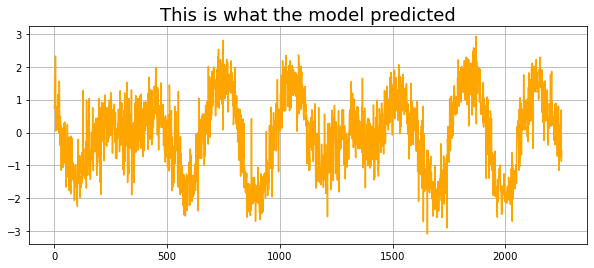

In [39]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

### Comparing it with the ground truth (test set)

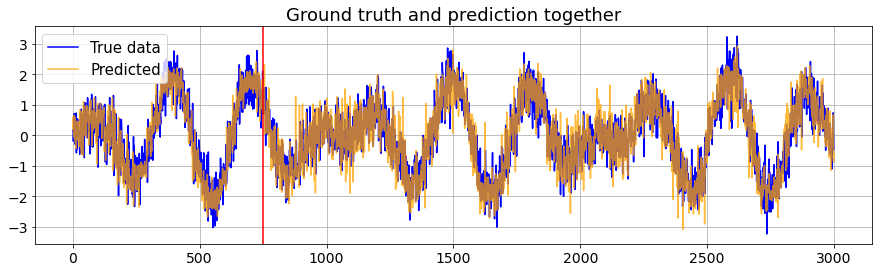

In [40]:
# el azul es el real y el amarillo es el predicho. El amarillo presenta el entrenamiento 

index = df.index.values
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index,df,c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How are the errors distributed?
The errors, or residuals, as they are called in a regression problem, can be plotted to see if they follow any specific distribution. In the generation process, we injected Gaussian noise, so we expect the error to follow the same pattern, _if the model has been able to fit to the real data correctly_.

In [41]:
error = predicted[Tp:N]-df[Tp:N]
error = np.array(error).ravel()

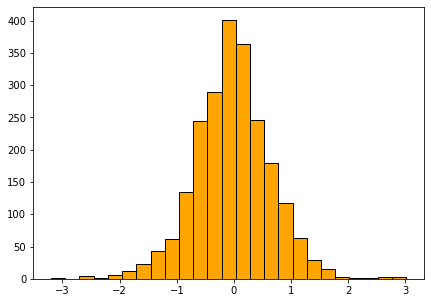

In [42]:
plt.figure(figsize=(7,5))
plt.hist(error,bins=25,edgecolor='k',color='orange')
plt.show()

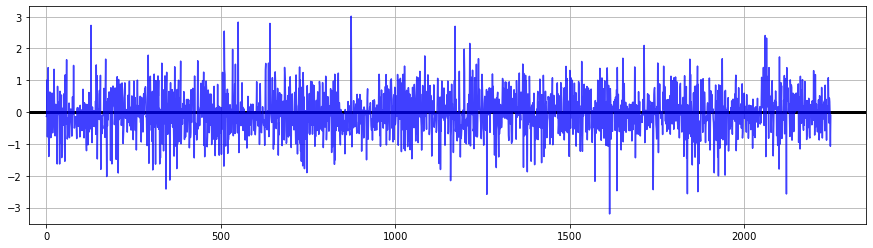

In [43]:
plt.figure(figsize=(15,4))
plt.plot(error,c='blue',alpha=0.75)
plt.hlines(y=0,xmin=-50,xmax=2400,color='k',lw=3)
plt.xlim(-50,2350)
plt.grid(True)
plt.show()

## Make the model better

Note, for running these experiments reasonably fast, we will fix the model size to be smaller than the model above. We will use a RNN layer with 32 neurons followed by a densely connected layer of 8 neurons.

### Varying the embedding/step size

In [44]:
def predictions(model,trainX,testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    predicted = np.concatenate((trainPredict,testPredict),axis=0)
    
    return predicted

In [45]:
def plot_compare(predicted):
    index = df.index.values
    plt.figure(figsize=(15,4))
    plt.title("Ground truth and prediction together",fontsize=18)
    plt.plot(index,df,c='blue')
    plt.plot(index,predicted,c='orange',alpha=0.75)
    plt.legend(['True data','Predicted'],fontsize=15)
    plt.axvline(df.index[Tp], c="r")
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [46]:
def prepare_data(step=4):
    values = df.values
    train, test = values[0:Tp,:], values[Tp:N,:]
    test = np.append(test,np.repeat(test[-1,],step))
    train = np.append(train,np.repeat(train[-1,],step))
    trainX, trainY =convertToMatrix(train,step)
    testX, testY =convertToMatrix(test,step)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX,testX,trainY,testY

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def errors(testX, df):
    y_true = df[Tp:N].values
    y_pred = model.predict(testX)
    error = y_pred - y_true
    return [mean_absolute_error(y_true=y_true, y_pred=y_pred)]

Embedding size: 2
Error: [0.3085088080652546]
----------------------------------------------------------------------------------------------------


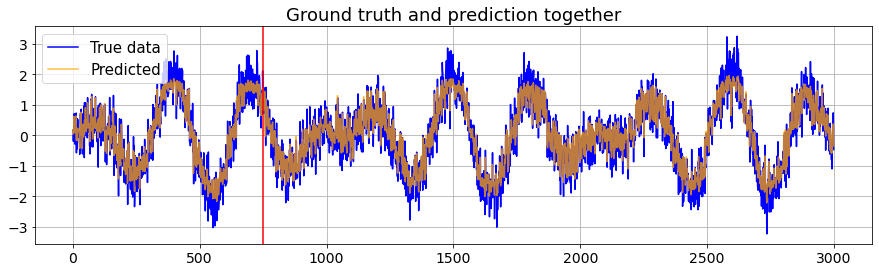


Embedding size: 4
Error: [0.37836821715131214]
----------------------------------------------------------------------------------------------------


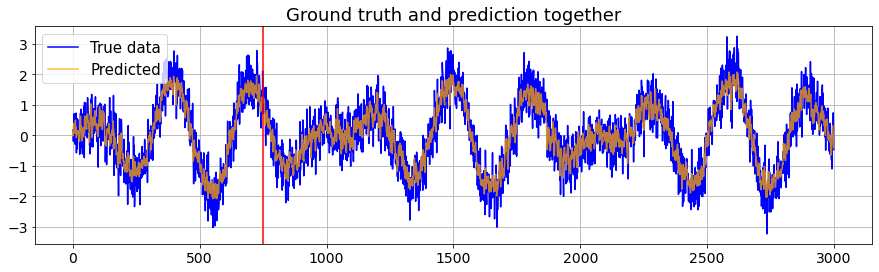


Embedding size: 6
Error: [0.3693259656663431]
----------------------------------------------------------------------------------------------------


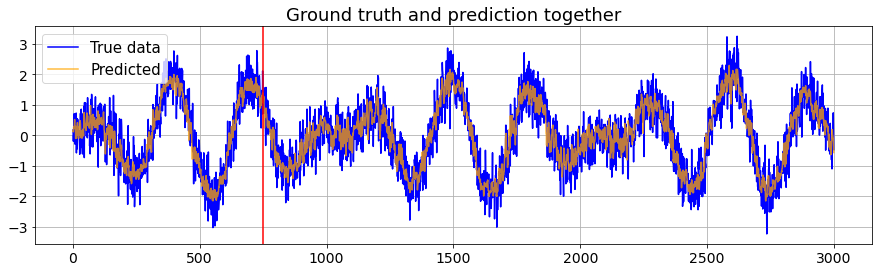


Embedding size: 8
Error: [0.43890608244439305]
----------------------------------------------------------------------------------------------------


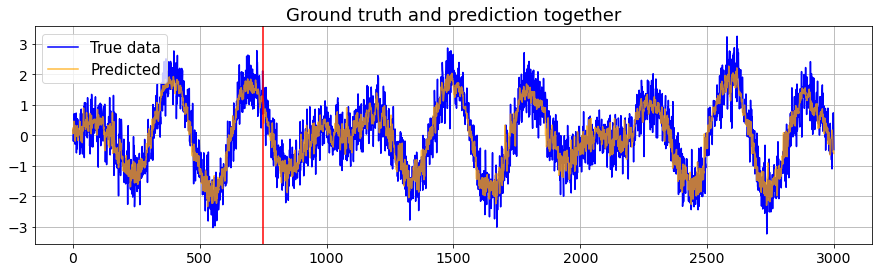


Embedding size: 10
Error: [0.4217928317787387]
----------------------------------------------------------------------------------------------------


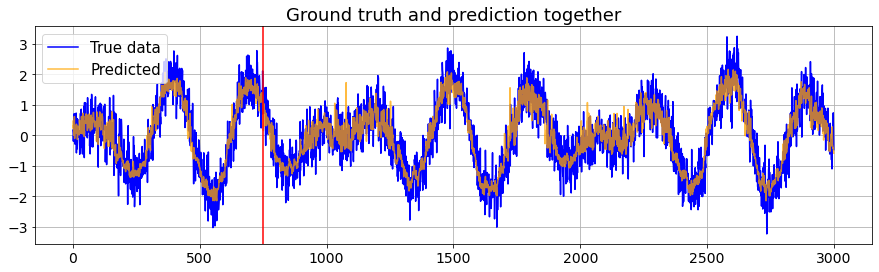


Embedding size: 12
Error: [0.4915083694250536]
----------------------------------------------------------------------------------------------------


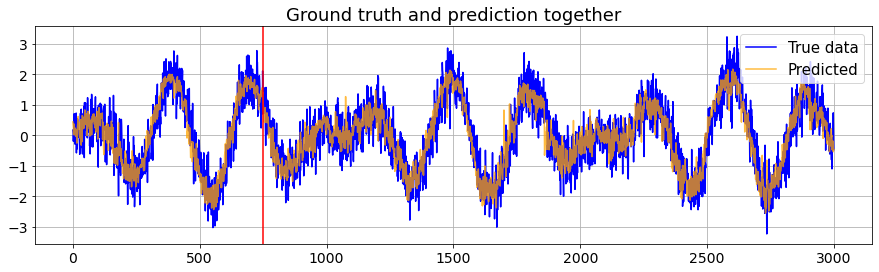

In [48]:
# Un for que va a cambiar el tamaño del step 
for s in [2,4,6,8,10,12]:
    trainX,testX,trainY,testY = prepare_data(s)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=s)
    batch_size=16
    num_epochs = 100
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Embedding size: {}".format(s))
    print("Error:", errors(testX, df))
    print("-"*100)
    plot_compare(preds)
    print()

### Number of epochs

Ran for 100 epochs
Error: [0.4362165888109516]
----------------------------------------------------------------------------------------------------


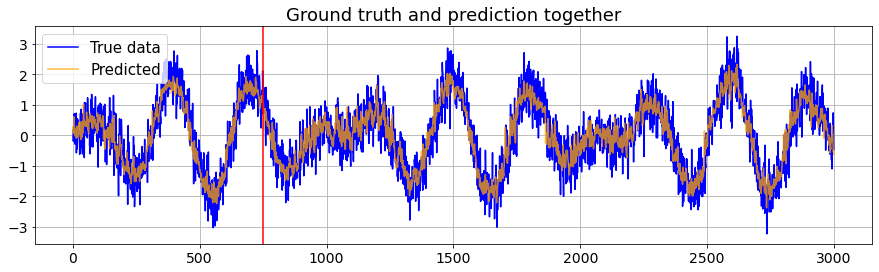


Ran for 200 epochs
Error: [0.44930512488534585]
----------------------------------------------------------------------------------------------------


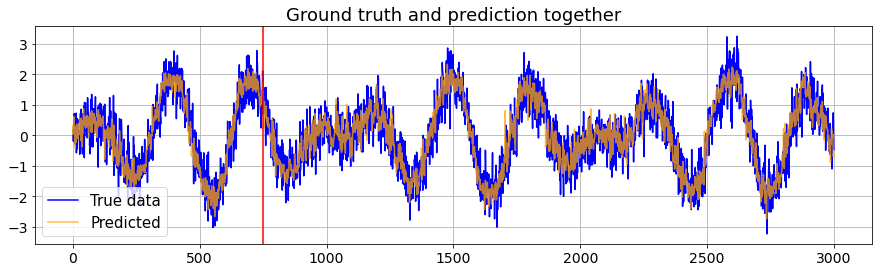


Ran for 300 epochs
Error: [0.47667299432989585]
----------------------------------------------------------------------------------------------------


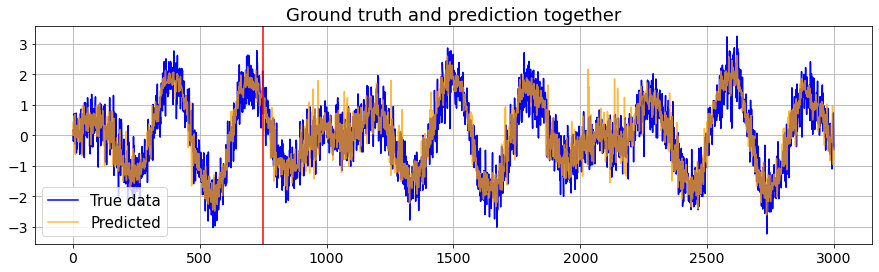


Ran for 400 epochs
Error: [0.5031921683433442]
----------------------------------------------------------------------------------------------------


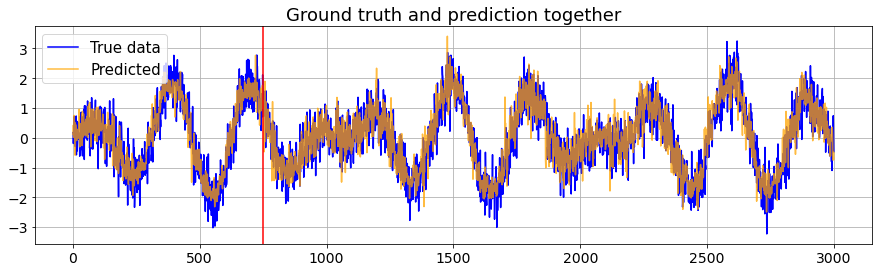


Ran for 500 epochs
Error: [0.5169359862734579]
----------------------------------------------------------------------------------------------------


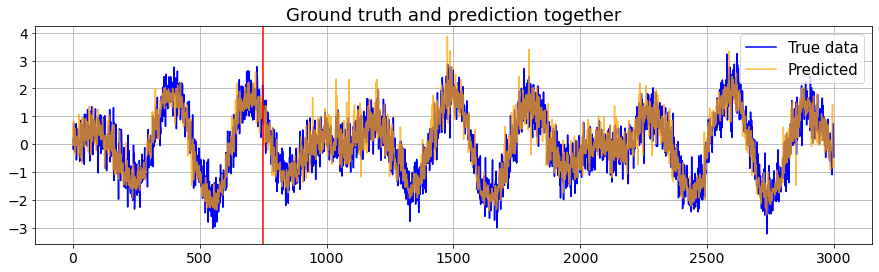

In [49]:
# cambiamos el número de epocas
for e in [100,200,300,400,500]:
    trainX, testX, trainY, testY = prepare_data(8) # le daba error a gabriel, aqui le puso un 2 en el parentesis 
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=8)
    batch_size=16
    num_epochs = e
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran for {} epochs".format(e))
    print("Error:", errors(testX, df))
    print("-"*100)
    plot_compare(preds)
    print()

### Batch size

Ran with batch size: 4
Error: [0.5079101930480271]
----------------------------------------------------------------------------------------------------


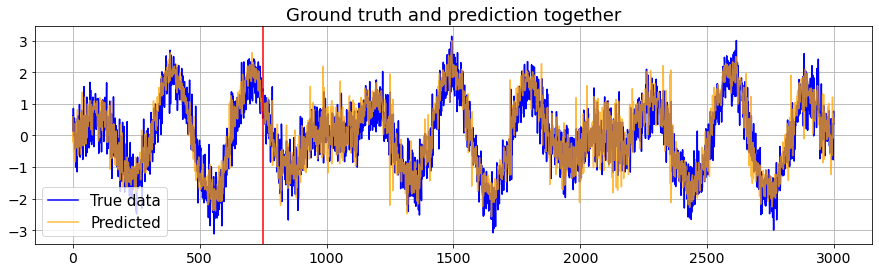


Ran with batch size: 8
Error: [0.44774210427208394]
----------------------------------------------------------------------------------------------------


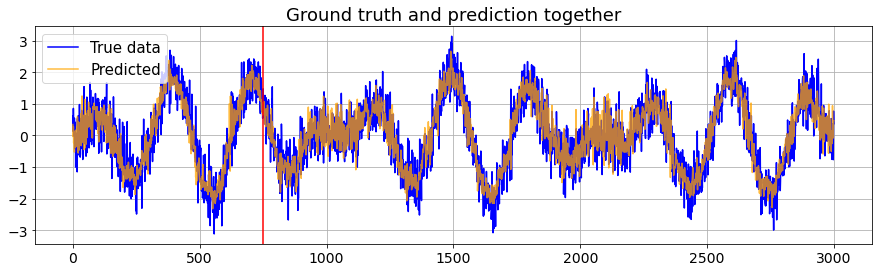


Ran with batch size: 16
Error: [0.46088518816796215]
----------------------------------------------------------------------------------------------------


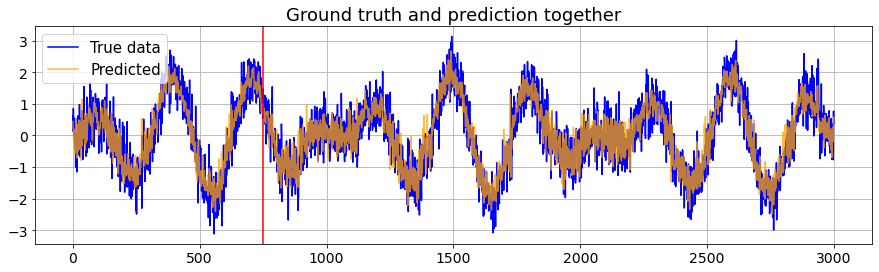


Ran with batch size: 32
Error: [0.43050694790899363]
----------------------------------------------------------------------------------------------------


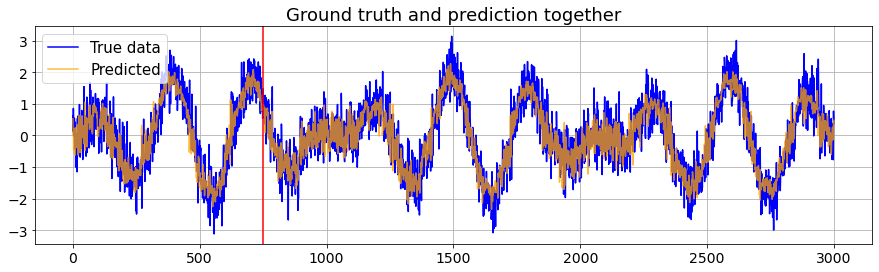


Ran with batch size: 64
Error: [0.4248371306406737]
----------------------------------------------------------------------------------------------------


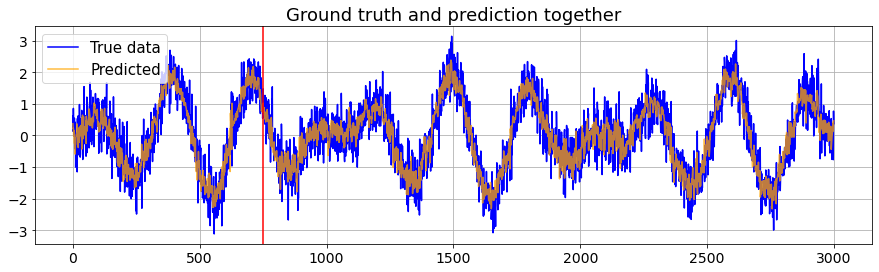

In [46]:
for b in [4,8,16,32,64]:
    trainX,testX,trainY,testY = prepare_data(8)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=8)
    batch_size=b
    num_epochs = 250
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran with batch size: {}".format(b))
    print("Error:", errors(testX, df))
    print("-"*100)
    plot_compare(preds)
    print()

### Summary

Clearly, following trends were observed,

- Too small embedding size is not useful but a very long embedding is also not effective. An embedding of 8 looks good for this data.
- More epochs are always better.
- A batch size of 32 or 64 looks optimal.

Ultimately, an exhaustive hyperparameter tuning is needed for the best overall performance. Also, the predictive power is not well-defined as we are judging the quality of the prediction mostly visually here but a neumerical metric (or a few of them) would be a better approach.